## clothes type & color classification

### Load Data

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

base = 'd:/multiLabel/clothes'

DATA_PATH = base+'clothes_dataset'
train_df = pd.read_csv(base + '/train.csv')
val_df = pd.read_csv(base + '/val.csv')
test_df = pd.read_csv(base + '/test.csv')

# print(train_df.head())

In [15]:
train_df.head()

,Unnamed: 0,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes
0,0,./clothes_dataset\blue_shorts\256d854b55ac32ea...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,./clothes_dataset\red_pants\584f778aece14f07c2...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,./clothes_dataset\green_pants\ec543ca241cefb2b...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,./clothes_dataset\brown_shorts\c8db9e0f7010592...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,./clothes_dataset\white_dress\551373c80717c5b0...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### Image Generator

In [16]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [17]:
train_datagen

### Define Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 합니다.
model.add(Flatten(input_shape = (112, 112, 3))) # (112, 112, 3) -> (112 * 112 * 3)
model.add(Dense(128, activation = 'relu')) # 128개의 출력을 가지는 Dense 층
model.add(Dense(64, activation = 'relu')) # 64개의 출력을 가지는 Dense 층
model.add(Dense(11, activation = 'sigmoid')) # 11개의 출력을 가지는 신경망

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

### Define Data Generator
- dataframe에서 data 읽어오기

In [19]:
train_df.head()

,Unnamed: 0,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes
0,0,./clothes_dataset\blue_shorts\256d854b55ac32ea...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,./clothes_dataset\red_pants\584f778aece14f07c2...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,./clothes_dataset\green_pants\ec543ca241cefb2b...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,./clothes_dataset\brown_shorts\c8db9e0f7010592...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,./clothes_dataset\white_dress\551373c80717c5b0...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [20]:
batch_size=32
class_col=train_df.columns[2:]
class_col

# Make Generator
############## 훈련 자료 : w,b를 갱신함
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base,    # train_df의 image 경로가 절대경로로 되어 있으면 생략해도 됨
    x_col = 'image',   # train_df['image']
    y_col = class_col,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    seed=42
)

############## model.fit 할 때 훈련자료에서 갱신된 w,b가 적합한지를 검증하는 자료
############## 보통 test data로 val을 많이 하지만 여기서는 val 자료를 별도로 가짐
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base,
    x_col = 'image',
    y_col = class_col,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True
)

Found 5578 validated image filenames.
Found 2391 validated image filenames.


c:\Users\user\miniconda3\envs\gpu\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Index(['black', 'shoes'], dtype='object')


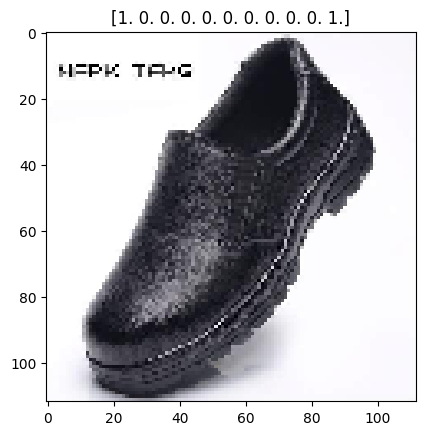

In [21]:
len(train_generator)  # 175 : 5578/32
train_generator[0]  # x,y 값
# 
train_generator[0][1]
# train_generator[0]

import matplotlib.pyplot as plt
plt.imshow(train_generator[0][0][0])
plt.title(train_generator[0][1][0])

np.where(train_generator[0][1][0]==1)  # 위치 값 찾기

train_generator[0][1][0]  # img, label, label의 label

for x in np.where(train_generator[0][1][0]==1):
    print(class_col[x])

In [22]:
# train_generator.take(0)


### Model Train

In [23]:
model.fit(train_generator,
         steps_per_epoch=get_steps(len(train_df), batch_size),  # get_steps : epoch를 얼마나 불러올지 결정
         validation_data = val_generator,
         validation_steps=get_steps(len(val_df), batch_size),
         epochs = 1)

175/175 [==============================] - 17s 88ms/step - loss: 0.5143 - acc: 0.3451 - val_loss: 0.2971 - val_acc: 0.4396


### Evaluate Model

In [24]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base,
    x_col='image',
    y_col=class_col,
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True
)

loss_and_metrics = model.evaluate(test_generator,
                                  steps=get_steps(len(test_df), batch_size))
print('loss_and_metrics : ' + str(loss_and_metrics)) 


Found 3416 validated image filenames.
107/107 [==============================] - 6s 60ms/step - loss: 0.2915 - acc: 0.4333
loss_and_metrics : [0.291473925113678, 0.43325525522232056]


### Save Model

In [25]:
import os

save_path = os.path.join('model', 'img_generator_model.h5')
model.save(save_path)

### Predict

In [26]:
######################### 테스트 추가

preds=model.predict(test_generator)
preds

array([[1.3351515e-01, 3.9334306e-01, 1.2145681e-01, ..., 7.9249786e-03,
        1.8985452e-02, 7.2641599e-01],
       [9.2887498e-02, 6.9700116e-01, 2.3568061e-01, ..., 4.1199155e-02,
        7.8989426e-03, 3.5279670e-01],
       [3.3118278e-02, 4.7263831e-01, 1.1398247e-01, ..., 9.2802949e-02,
        1.1476614e-01, 7.5052965e-01],
       ...,
       [1.3878520e-01, 1.7660764e-03, 1.7692594e-01, ..., 4.2525271e-01,
        1.4284655e-03, 4.6763152e-01],
       [1.1796707e-01, 2.9870102e-01, 9.8651193e-02, ..., 2.4771410e-01,
        2.8960414e-02, 9.1546066e-02],
       [4.7277231e-02, 3.0234319e-04, 1.6895939e-01, ..., 3.1937011e-02,
        1.9617499e-04, 4.5812035e-01]], dtype=float32)

In [27]:
# preds[0]
# # 11개의 결과 값

# ############################# 첫번째, 두번째로 큰 값을 찾고 그 위치를 찾음
# np.argmax(preds[0])
# class_col[np.where(preds[0]=='가장 큰 값')]
# class_col[np.where(preds[0]=='두번째로 큰 값')]

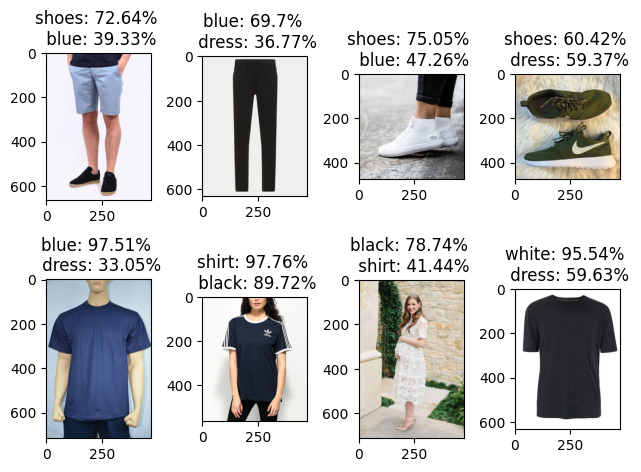

In [28]:
import cv2

do_preds = preds[:8]

for i, pred in enumerate(do_preds):
    plt.subplot(2, 4, i + 1)
    prob = zip(class_col, list(pred))
    # item --> prob
    # contributor: '뱅커'님
    prob = sorted(list(prob), key = lambda z: z[1], reverse = True)[:2]

    image = cv2.imread(base+test_df['image'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(f'{prob[0][0]}: {round(prob[0][1] * 100, 2)}% \n {prob[1][0]}: {round(prob[1][1] * 100, 2)}%')

plt.tight_layout()

In [29]:
#### 만약 한개의 자료만 갖고서 예측한다면
## 새로운 데이터로 해야하지만
# 테스트자료 한개 꺼내서 예측하고자함

# from PIL import Image

# base='D:/multiLabel/clothes/'
# file=base+'./clothes_dataset/black_pants/0f8eb4509cea01f9656e8b31e3af0d29852cd90e.jpg'   
# img=Image.open(file).resize((112,112))
# img=np.array(img)

# plt.imshow(img)
# x_test=img.reshape(1, 112,112,3)
# yhat = model.predict(x_test)

# for x in np.where(yhat[0]==1)[0]:
#     print(class_col[x])